In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from PIL import Image
import yaml
from utils import *
from helpers import *
import pickle

import pdb
from tqdm import tqdm

from dlclive import DLCLive, Processor

In [12]:
class DataManager:
    def __init__(self, keys=[]):
        self.data = {key: [] for key in keys}
    
    def _print_key_error(self, key):
        print(f"Key '{key}' does not exist in the data manager.")

    def add_nan(self, key, shape):
        data_ = self.data[key]
        pop_count = 0
        while len(data_) > 0 and data_[-1] is None:
            data_.pop()
            pop_count += 1
        while pop_count > 0:
            data_.append(np.full(shape, np.nan))
            pop_count -= 1

    def add(self, key, value):
        if key in self.data:
            if value is not None:
                self.add_nan(key, value.shape)
            self.data[key].append(value)
        else:
            self._print_key_error(key)

    def to_numpy(self):
        for key in self.data:
            data_ = self.data[key]
            if len(data_) == 0 or data_[0] is None:
                self.data[key] = None
                return
            self.add_nan(key, data_[0].shape)
            self.data[key] = np.array(data_)

    def save(self, dir):
        for key in self.data:
            np.save(f'{dir}/{key}.npy', self.data.get(key))

    def load(self, dir, keys):
        if keys is None:
            keys = self.data.keys
        for key in keys:
            self.data[key] = np.load(f'{dir}/{key}.npy')
        return self.data

    def remove(self, key):
        if key in self.data:
            del self.data[key]
        else:
            self._print_key_error(key)

    def get(self, key):
        if key in self.data:
            return self.data[key]
        else:
            self._print_key_error(key)
            return None

In [13]:
class DLCManager:
    def __init__(self, 
            model_path,
            processor=Processor(),
            pcutoff=0.2,
            resize=1):
        
        self.model = DLCLive(
            model_path=model_path,
            processor=processor,
            pcutoff=pcutoff,
            # display=True,
            resize=resize)
        self.frame = None
        self.is_first_frame = None
        self.dm = DataManager()

    def init_data(self, feature_keys):
        self.dm = DataManager(feature_keys)
        self.prev_pose_xy = None
        
    def update_frame(self, frame, is_first_frame):
        self.frame = frame
        self.is_first_frame = is_first_frame
        
    def detect_pose_helper(self):
        if self.is_first_frame:
            pose = self.model.init_inference(self.frame)
        else:
            pose = self.model.get_pose(self.frame)
        return pose
        
    def detect_pose(self):
        curr_pose = self.detect_pose_helper()
        
        curr_pose_xy, curr_pose_p = curr_pose[:, :-1], curr_pose[:, -1]
        if self.prev_pose_xy is None:
            self.prev_pose_xy = curr_pose_xy

        pose = np.stack([self.prev_pose_xy, curr_pose_xy])
        feature_angles_item, pose_speed_item = extract_pose_features(pose)

        self.dm.add('xy', curr_pose_xy)
        self.dm.add('p', curr_pose_p)
        self.dm.add('angles', feature_angles_item)
        self.dm.add('speed', pose_speed_item)

        self.prev_pose_xy = curr_pose_xy

    def save_data(self, dir):
        self.dm.to_numpy()
        self.dm.save(dir)

    def load_data(self, dir, feature_keys):
        return self.dm.load(dir, feature_keys)

In [14]:
class Driver:
    def __init__(self, config_file, dev_mode = False, video_type="Elec", verbose = True):
        with open(f'configs/{config_file}.yaml', 'r') as file:
            config = yaml.safe_load(file)
        self.is_metadata_present = (config['path']['xls'] is not None)
        self.fps = config['info']['fps']
        root_dir = config['path']['root']
        ## Updated -->
        self.video_dir = config['path']['video']

        if self.is_metadata_present:
            xls_path = f"{root_dir}/{config['path']['xls']}"
            self.files_info = read_octopus_xlsx(xls_path)
            if video_type == "Mech":
                self.files_info = self.files_info[self.files_info['Stim Method'] == 'Mechanical']
            elif video_type == "Elec":
                self.files_info = self.files_info[self.files_info['Stim Method'] == 'Electrical']
            else:
                pass
                
            self.filenames = self.files_info["File Name"].to_list()
        else:
            self.filenames = [os.path.splitext(file)[0] for file in os.listdir(self.video_dir)]

        self.working_dir = f"{root_dir}/{config['path']['working']}" # to save processed data and figures

        model_path = f"{root_dir}/{config['path']['model']}"

        self.feature_keys = ['xy', 'p', 'angles', 'speed']
        self.dlc = DLCManager(model_path)
        
        self.prosvd_k = 4 # no. of dims to reduce to

        self.time_margin = (-120, 180) # to trim videos
        self.total_f = self.time_margin[1] - self.time_margin[0]

        self.init_frame_crop = 10 # No of initial frames used to set cropping info
        self.init_frame_prosvd = 90 # No of initial frames used to initialize proSVD
        self.init_frame = self.init_frame_crop + self.init_frame_prosvd

        self.tx = np.arange(self.init_frame + self.time_margin[0], self.time_margin[1])/self.fps

        if self.is_metadata_present:
            self.stim_class_list = sorted(self.files_info['Stimulation Class'].unique().tolist())
        else:
            self.stim_class_list = np.array(['Cord Electrical', 'Distal Electrical', 'Proximal Electrical', 'Cord Mechanical', 'Distal Mechanical', 'Proximal Mechanical'])

        if dev_mode:
            self.files_info = self.files_info.iloc[[2]]
            self.filenames = self.files_info["File Name"].to_list()

        if verbose:
            print(f"Processing {len(self.filenames)} videos from {self.video_dir}")
            if len(self.filenames) < 4:
                print('\t', end='')
                print(*self.filenames, sep="\n\t")

    def get_fig_dir(self, filename):
        figs_dir = f"{self.working_dir}/figs"
        os.makedirs(figs_dir, exist_ok=True)
        return figs_dir

    def get_data_dir(self, filename=None):
        if filename is None:
            data_dir = f"{self.working_dir}"
        else:
            data_dir = f"{self.working_dir}/data/{filename}"
        os.makedirs(data_dir, exist_ok=True)
        return data_dir
    
    def load_video(self, video_idx):
        video_filename = self.filenames[video_idx]

        self.video = None
        try:
            self.video = load_video(self.video_dir, video_filename)
        except:
            return False

        self.index = -1

        self.dlc.init_data(feature_keys=self.feature_keys)

        return (self.video is not None)
    
    def is_video_empty(self):
        return self.video is None or not self.video.isOpened()
    
    def read_video(self):
        ret, self.frame = self.video.read()
        if not ret: return False
        # if not self.frame:
        #     pdb.set_trace()
        self.frame = self.frame[:,:,::-1]
        self.index += 1
        self.dlc.update_frame(self.frame, self.index == 0)
        return ret
    
    def release_video(self):
        self.video.release()
    
    def detect_pose(self):
        self.dlc.detect_pose()

    def save_data(self, video_idx):
        video_filename = self.filenames[video_idx]
        data_dir = self.get_data_dir(video_filename)
        self.dlc.save_data(data_dir)

    def post_process(self, verbose=False):
        err_log = {
            'poor_pose': [],
            'file_missing': []
        }

        columns = ['filename', *self.feature_keys, 'move_class', 'stim_class']
        df = pd.DataFrame(columns=columns)

        for video_idx in range(len(self.filenames)):
            video_filename = self.filenames[video_idx]

            data_dir = self.get_data_dir(video_filename)

            try:
                features = self.dlc.load_data(data_dir, self.feature_keys)
            except ValueError:
                err_log['poor_pose'].append(video_filename)
                continue
            except FileNotFoundError:
                err_log['file_missing'].append(video_filename)
                continue
            except:
                raise("Uncaught exception")
            
            row = None
            if self.is_metadata_present:
                row = self.files_info.iloc[video_idx]
            md = load_metadata_new(row, time_margin = self.time_margin)

            start_f, end_f = self.init_frame + md[0], md[1]

            data = {}

            for key, value in features.items():
                data[key] = value[start_f: end_f, ...]

            move_idx, stim_idx = 0, 0
            if self.is_metadata_present:
                move_idx = int(row['Classification'])
                stim_class = row["Stimulation Class"]
                stim_idx = self.stim_class_list.index(stim_class)

            data['filename'] = video_filename
            data['move_class'] = move_idx
            data['stim_class'] = stim_idx

            df = df.append(data, ignore_index=True)

        if verbose:
            for key, items in err_log.items():
                print(f"{key}: {len(items)}")
                for item in items:
                    print(f"\t{item}")

        data_dir = self.get_data_dir()

        feature_key_tuple = [('features', key) for key in self.feature_keys]

        df.columns = pd.MultiIndex.from_tuples([
            ('metadata', 'filename'),
            *feature_key_tuple,
            ('labels', 'move_class'),
            ('labels', 'stim_class')
        ])

        # df = df.fillna(0)

        with open(f'{data_dir}/features.pkl', 'wb') as f:
            pickle.dump(df, f)

    def visualize_results(self):
        num_lines = 3 # for 3 angles
        colors = plt.cm.Paired(np.linspace(0, 1, num=num_lines))

        num_rows, num_cols = 1, 3
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4), gridspec_kw={'top': 0.85})

        for i, key in enumerate(self.feature_angles_dict.keys()):
            feature_angle_mean = np.mean(self.feature_angles_dict[key], axis=0)

            for k in range(3):
                data = feature_angle_mean[..., k]
                data = smooth_data(data, 5)
                axs[i].plot(data, label=k, linewidth=2, c=colors[k])
            axs[i].set_ylim(-10, 190)
            axs[i].set_title(key)
            axs[i].set_xlabel("Time (s)")
            axs[i].axvline(x=0, color='orange', linewidth=2, alpha=0.3)

        legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=i) for i in range(3)]
        fig.legend(title="Angle", handles=legend_elements, loc='upper right')
        fig.suptitle(f'Electrical Stimulations - Angle')

        figs_dir = self.get_fig_dir("")
        figs_dir_full = f'{figs_dir}/dlc-summary'
        os.makedirs(figs_dir_full, exist_ok=True)
        fig.savefig(f'{figs_dir_full}/Electrical Stimulations - Angle.png', facecolor='white')
    

In [15]:
driver = Driver("zebrafish")

Processing 1 videos from /home/sachinks/Code/stim_behavior/data/video
	zebrafish_smoothed


In [16]:
for video_idx in tqdm(range(len(driver.filenames))):
    ret = driver.load_video(video_idx)
    if not ret:
        continue

    while not driver.is_video_empty():
        ret = driver.read_video()
        if not ret:
            break

        driver.detect_pose()

    driver.release_video()

    driver.save_data(video_idx)

driver.post_process()

  0%|          | 0/1 [00:00<?, ?it/s]2023-08-24 10:59:57.763955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 10:59:57.764061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/cv2/../../lib64:
2023-08-24 10:59:57.764093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/cv2/../../lib64:
2023-08-24 10:59:57.764116: W tensorflow/stream_executor/platform/default/dso_loade

In [18]:
# Helper functions

def fill_nan_linear_interpolation_axis(arr, axis):
    def fill_nan_linear_interpolation(row):
        nan_mask = np.isnan(row)
        nan_len = np.sum(nan_mask)
        indices = np.arange(len(row))
        row[nan_mask] = np.interp(indices[nan_mask], indices[~nan_mask], row[~nan_mask])
        return row
    return np.apply_along_axis(fill_nan_linear_interpolation, axis, arr)

def compute_L(xy):
    feat = xy
    feat = np.diff(feat, axis=-2)
    feat = np.square(feat)
    feat = np.sqrt(np.sum(feat, axis=-1))
    L = np.sum(feat, axis=-1)
    return L

def find_speed(xy):
    def normalize(speed):
        L = compute_L(xy)
        L = L.mean()
        speed /= L
        return speed

    pose_vel = np.diff(xy, axis=0)
    pose_speed = np.linalg.norm(pose_vel, axis=-1).squeeze()
    pose_speed = np.insert(pose_speed, 0, 0, axis=0)
    pose_speed = normalize(pose_speed)
    return pose_speed

def clean_XY_by_speed(xy):
    pose_speed = find_speed(xy)
    xy[pose_speed > 0.4] = np.nan
    xy = fill_nan_linear_interpolation_axis(xy, axis=0)
    return xy

def find_point_point_distance(xy):
    feat = xy
    feat = np.diff(feat, axis=-2)
    feat = np.square(feat)
    feat = np.sqrt(np.sum(feat, axis=-1))

    L = np.sum(feat, axis=-1, keepdims=True)
    feat /= L

    IDEAL_LENGTH = np.array([1/2, 1/4, 1/8, 1/8])
    feat -= IDEAL_LENGTH
    feat = np.linalg.norm(feat, axis=-1)
    return feat

def clean_XY_by_point_position(xy):
    pp_distance = find_point_point_distance(xy)
    xy[pp_distance > 0.25] = np.nan
    # pdb.set_trace()
    xy = fill_nan_linear_interpolation_axis(xy, axis=0)
    return xy

# Load features

def load_features(proSVD=True, verbose=True):
    data_dir = driver.get_data_dir()
    with open(f'{data_dir}/features.pkl', 'rb') as f:
        df = pickle.load(f)
    df.drop([('features', 'angles'), ('features', 'speed')], axis=1, inplace=True)
    
    if proSVD:
        with open(f'{data_dir}/proSVD_features.pkl', 'rb') as f:
            df_prosvd = pickle.load(f)

        assert(len(df) == len(df_prosvd))

        ins_pos = df.columns.get_loc(('labels', 'move_class'))
        df.insert(ins_pos, ('features', 'prosvd'), df_prosvd['features'].values)

    if verbose:
        print(df.shape)
        display(df.head(2))
    return df

# Add features

def add_features(df, skeleton_thresh=0.4):
    def add_columns(key, fn):
        new_column_data = df.apply(fn, axis=1)
        ins_pos = df.columns.get_loc(('labels', 'move_class'))
        df.insert(ins_pos, ('features', key), new_column_data)

    def compute_speed(row):
        xy = row[('features', 'xy')]
        return find_speed(xy)

    def compute_skeleton(row):
        xy = row[('features', 'xy')]
        return find_point_point_distance(xy)

    def compute_pred_acc(row):
        skeleton = row[('features', 'skeleton')]
        acc = np.sum(skeleton < skeleton_thresh)/len(skeleton)
        return acc

    add_columns('speed', compute_speed)    
    add_columns('skeleton', compute_skeleton)

    new_column_data = df.apply(compute_pred_acc, axis=1)
    ins_pos = df.columns.get_loc(('labels', 'stim_class'))
    df.insert(ins_pos+1, ('labels', 'pred_acc'), new_column_data)

    return df
# Load & Add

df_features = load_features(proSVD=False, verbose = False)
df_features = add_features(df_features, skeleton_thresh=0.4)

In [49]:
tx_len = len(df_features[[('features', 'xy')]].iloc[0].values[0])
driver.tx = np.arange(0, tx_len/driver.fps, 1/driver.fps)

In [53]:
len(x_vals)

10

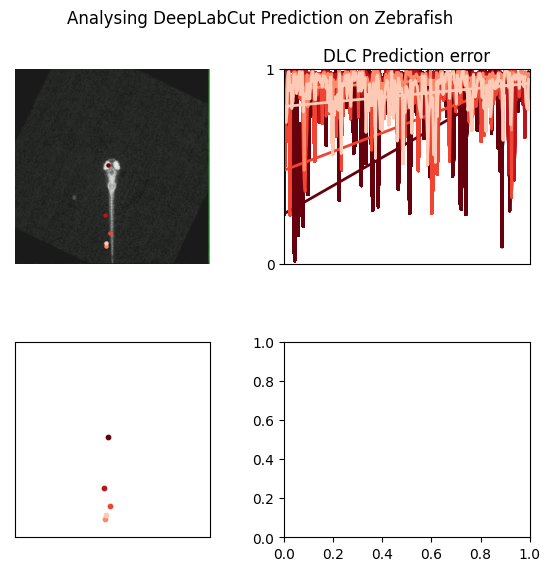

In [56]:
# Visualize DLC prediction (same size frames)

df_features = load_features(proSVD=False, verbose = False)
df_features = add_features(df_features, skeleton_thresh=0.4)

list_of_indices = [0]

import matplotlib.pyplot as plt
import matplotlib.animation as animation

colors = plt.cm.Reds(np.linspace(1, 0.2, num=5))
# colors = plt.cm.Paired(np.linspace(0.2, 0.8, num=5))

for video_idx in list_of_indices:#range(df_features.shape[0]): # df_features.shape[0]
    start_at = None
    end_at = None

    if driver.is_metadata_present:
        row = driver.files_info.iloc[video_idx]
        print(f"{video_idx}: Move ({row['Classification']}) - {row['File Name']}")
        md = load_metadata_new(row, time_margin = (-20, 180))
        start_f, end_f = md[0], md[1]
    else:
        md = [0]
        start_f, end_f = 0, 259

    if start_at:
        start_f = md[0] + start_at

    if end_at:
        end_f = md[0] + end_at

    x_vals = driver.tx[start_at:end_at]

    driver.load_video(video_idx)

    driver.video.set(cv2.CAP_PROP_POS_FRAMES, start_f)

    XY = df_features.iloc[video_idx]['features','xy'][start_at:end_at]
    XY = clean_XY_by_speed(XY)
    # XY = clean_XY_by_point_position(XY)

    p_like = df_features.iloc[video_idx]['features', 'p'][start_at:end_at]

    # proSVD_q = df_features.iloc[video_idx]['features', 'prosvd'][start_at:end_at]

    pose_vel = np.diff(XY, axis=0)
    pose_speed = np.linalg.norm(pose_vel, axis=-1).squeeze()
    pose_speed = np.insert(pose_speed, 0, 0, axis=0)

    num_rows, num_cols = 2, 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3,num_rows*3))
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.10)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    fig.suptitle(f"Analysing DeepLabCut Prediction on Zebrafish")

    x_data = []

    y_data_1 = []

    y_data_2 = [[] for _ in range(pose_speed.shape[-1])]

    y_data_3 = []

    y_data_4 = []

    y_data_5 = [[] for _ in range(pose_speed.shape[-1])]

    y_data_6 = []

    y_data_prosvd_1 = [[] for _ in range(2)]

    L_list = []

    # colors = plt.cm.Reds(np.linspace(1, 0.2, num=5))


    # Function to update the plot with each frame
    def update(frame_idx):
        def get_cropbox():
            asp_ratio = 640/480
            x1, x2 = 140, 520
            ym = 320
            ydiff = int(0.5*(x2-x1)/asp_ratio)
            y1, y2 = ym-ydiff, ym+ydiff
            return x1, x2, y1, y2

        def plot_scatter(ax, frame, xy):
            ax.clear()
            ax.set_xlim(0, frame.shape[1])
            ax.set_ylim(frame.shape[0], 0)
            # x1, x2, y1, y2 = get_cropbox()
            # ax.set_xlim(x1, x2)
            # ax.set_ylim(y2, y1)
            ax.set_aspect('equal', adjustable='box')

            for i, (x, y) in enumerate(xy):
                ax.scatter(x, y, color=colors[i], label=f"Point {i+1}", s=10)
            ax.set_xticks([])
            ax.set_yticks([])

        def plot_video(ax, frame, xy):
            ax.clear()

            # x1, x2, y1, y2 = get_cropbox()
            # ax.set_xlim(x1, x2)
            # ax.set_ylim(y2, y1)
            # pdb.set_trace()
            # frame = frame[y1:y2, x1:x2, ...]
            ax.imshow(frame, alpha=0.9)

            # colors = plt.cm.Reds(np.linspace(1, 0.2, num=xy.shape[0]))
            for i, (x, y) in enumerate(xy):
                ax.scatter(x, y, color=colors[i], label=f"Point {i+1}", s=5)
            
            # ax.set_title(f"Video")
            ax.axis('off')

        def plot_octo_length(ax, xy):
            line, = ax.plot([], [], lw=2, color='blue')
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_ylim(0, 400)
            ax.set_title(f"Length")

            L = compute_L(xy)
            y_data_1.append(L)
            
            line.set_data(x_data, y_data_1)

        def plot_octo_length_var_1(ax, xy):
            line, = ax.plot([], [], lw=2, color='blue')
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_ylim(0, 1)
            ax.set_title(f"Length Variation")

            feat = xy
            feat = np.diff(feat, axis=-2)
            feat = np.square(feat)
            feat = np.sqrt(np.sum(feat, axis=-1))

            cur_L = np.sum(feat, axis=-1)
            mean_L = np.mean(L_list[-90:])
            L_var = np.abs(cur_L-mean_L)/mean_L

            y_data_4.append(L_var)
            
            line.set_data(x_data, y_data_4)

        def plot_octo_length_var_2(ax, xy):
            line, = ax.plot([], [], lw=2, color='blue')
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_ylim(0, 1)
            ax.set_title(f"Length Variation")

            L_diff = 0
            if len(L_list) > 1:
                L_diff = np.abs(L_list[-1]-L_list[-2])
                L_diff /= L_list[-2]
            
            y_data_6.append(L_diff)
            
            line.set_data(x_data, y_data_6)

        def plot_likelihood(ax, p_el):
            # line, = ax.plot([], [], lw=2, color='red')
            num_lines = p_el.shape[-1]
            lines = [ax.plot([], [], lw=2, color=colors[i])[0] for i in range(num_lines)]
            
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_title(f"DLC Prediction error")

            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([0, 1])

            for i in range(num_lines):
                y_data_2[i].append(1-p_el[i])
                lines[i].set_data(x_data, y_data_2[i])

        def plot_prosvd(ax, pro_q):
            colors = plt.cm.Paired(np.linspace(0.2, 0.8, num=2))
            num_lines = 2
            lines = [ax.plot([], [], lw=2,
             color=colors[i])[0] for i in range(num_lines)]
            
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_title(f"proSVD components")

            ax.set_ylim(0, 1)
            ax.set_xlabel("Time (s)")
            ax.set_yticks([0, 1])


            for i in range(num_lines):
                y_data_prosvd_1[i].append(pro_q[i])
                lines[i].set_data(x_data, y_data_prosvd_1[i])
            # ax.legend()
        

        def plot_relative_length(ax, xy):
            line, = ax.plot([], [], lw=2, color='orange')
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_ylim(0, 1)
            ax.set_title(f"Deformation")
            
            feat = xy
            feat = np.diff(feat, axis=-2)
            feat = np.square(feat)
            feat = np.sqrt(np.sum(feat, axis=-1))

            L = np.sum(feat, axis=-1)
            feat /= L

            IDEAL_LENGTH = np.array([1/2, 1/4, 1/8, 1/8])
            feat -= IDEAL_LENGTH
            
            feat = np.linalg.norm(feat, axis=-1)
            y_data_3.append(feat)
            
            line.set_data(x_data, y_data_3)

        def plot_speeds(ax, speed):
            num_lines = speed.shape[-1]
            lines = [ax.plot([], [], lw=2, color=colors[i])[0] for i in range(num_lines)]
            ax.set_xlim(x_vals[0], x_vals[-1])
            ax.set_ylim(0, 1)
            ax.set_title(f"Speed of points")
            mean_L = np.mean(L_list[-90:])

            for i in range(num_lines):
                y_data_5[i].append(speed[i]/mean_L)
                lines[i].set_data(x_data, y_data_5[i])

        x_data.append(x_vals[frame_idx])

        xy = XY[frame_idx]
        L_list.append(compute_L(xy))

        # Video
        ret, frame = driver.video.read()
        frame = frame[:,:,::-1]
        plot_video(axs[0, 0], frame, xy)

        # Points
        plot_scatter(axs[1, 0], frame, xy)
        
        # Length variation
        # plot_octo_length_var_1(axs[0, 2], xy)
        # plot_octo_length_var_2(axs[0, 2], xy)

        # proSVD
        # plot_prosvd(axs[1, 1], proSVD_q[frame_idx][1:-1])

        # Prediction
        p_el = p_like[frame_idx]
        plot_likelihood(axs[0, 1], p_el)

        # Point to point distance variation
        # plot_relative_length(axs[1, 1], xy)

        # Speed (normalized)
        # plot_speeds(axs[1, 2], pose_speed[frame_idx])

        # Length
        # plot_octo_length(axs[2, 0], xy)


    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=end_f-start_f, interval=50)

    # # Save the animation as a GIF
    output_gif_path = f'dlc_1/plot_{video_idx:0{3}d}.gif'
    ani.save(output_gif_path, writer='pillow', fps=20);

# # Show the plot
# plt.show()